
3D MRI Super Resolution
==============
Author: Huixiang Zhuang, Hadrien Cornier




##  Overview

Magnetic resonance imaging (MRI) is a powerful diagnostic imaging technique. But the biggest problem is the trade off between high quality scan and long scanning time. High resolution MRI are hardware demanding, and prone to motion artifacts. Nowadays, neural network researches on image superresolution have focus on MR super resoltuion, in order to make cheaper, and faster scans.

We referred to multi-level densely connected super-resolution network (mDCSRN) and merged it with the idea of generative adversarial learning, to perform super resolution on MR images. 

In [1]:
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import random
import time
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from scipy import ndimage
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
# from torch.optim import lr_scheduler


# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Input

**Parameter setting**

Here we define some inputs for the run:

-  **vm_PATH** - the path of folder in your local machine that mounts google storage 
-  **id_csv** - the path to the .csv file that has id of subjects
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size here in fact determine the number of samples once download. We uses a batch size of 2
-  **patch_size** - the patch size here in fact determine the number of images (cubes) as the input in one training. We uses a patch size of 2 as is recommended in the paper
-  **cube_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **usage** - the usage of a patch cluster. usage < 1.0 would mean we choose to randomly give up some patches by this probability
-  **num_steps_pre** - the pretraining steps of Generator. By default in paper, this should be 500000. Here we use 250000. 
-  **num_steps** - the total steps of training. By default in paper, this should be $500000+550000=1050000$. Here we use 550000. 
-  **first_steps** - the total number of WGAN Discriminator pre-training steps. By default in paper, this should be 10000. Here we use 10000.
-  **lr_pre** - learning rate for pretraining. As described in the paper, this number should be 1e-4.
-  **lr** - learning rate for WGAN training. As described in the paper, this number should be 5e-6.
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs
-  **device** - CUDA setting. 



In [2]:
# Set pathes
vm_PATH = "./mnt/superresolution/HCP_1200/"
id_csv = './csv/id_hcp.csv'

# Number of workers for dataloader
workers = 1

# Batch size. It controls the number of samples once download
batch_size = 16

# Patch size, it controls the number of patches once send into the model
patch_size = 2

# The size of one image patch (eg. 64 means a cubic patch with size: 64x64x64)
cube_size = 64

# Set the usage of a patch cluster.
usage = 1.0

# Number of mDCSRN (G) pre-training steps (5e6)
num_steps_pre = 250000

# Number of WGAN training steps (1.5e7)
num_steps = 450000

# Number of WGAN D pre-training steps (1e4)
first_steps = 10000

# Learning rate for mDCSRN (G) pre-training optimizers (in paper: 1e-4)
lr_pre = 1e-4

# Learning rate for optimizers (in paper: 5e-6)
lr = 5e-6

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

# set GPU device
os.environ['CUDA_VISIBLE_DEVICES']='0,1'
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Data loading with online fetching, and patching



In [3]:
from ecbm6040.dataloader.CustomDatasetFromCSV import CustomDatasetFromCSV

from ecbm6040.patching.patchloader import patching

**Split data**

In [4]:
# Set percentage of data spliting
train_split= 0.7
validate_split = 0.1
evaluate_split = 0.1
test_split = 0.1

# Set shuffle and stablize random_seed
shuffle_dataset = True
random_seed= 999

# load data from csv
dataset = CustomDatasetFromCSV(id_csv,vm_PATH)
dataset_size = len(dataset)

# get indices for spliting train, valiadate, evaluate, test sets
train_size = math.ceil(train_split * dataset_size)
validate_size = int(validate_split * dataset_size)
evaluate_size = int(evaluate_split * dataset_size)
test_size = int(dataset_size - train_size - validate_size - evaluate_size)

indices = list(range(dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices = indices[:train_size]
# To reduce computational cost in validation period, you can intentionally decrease the validation size. 
loc_val = train_size + validate_size
# loc_val_reduced = train_size + math.ceil(validate_size/3)
# val_indices = indices[train_size:loc_val_reduced]
val_indices = indices[train_size:loc_val]
loc_eval = loc_val + evaluate_size
eval_indices = indices[loc_val:loc_eval]
test_indices = indices[loc_eval:loc_eval+10]
num_train = len(train_indices)
num_val = len(val_indices)
num_eval = len(eval_indices)
num_test = len(test_indices)
print('training set number:{}'.format(len(train_indices)))
print('validation set number:{}'.format(len(val_indices)))
print('evaluation set number:{}'.format(len(eval_indices)))
print('test set number:{}'.format(len(test_indices)))

training set number:780
validation set number:111
evaluation set number:111
test set number:10


**The following cell create dataloaders used for pretraining.**

In [5]:
# Use for pre-training (we don't want too much validation)
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
eval_sampler = SubsetRandomSampler(eval_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=train_sampler,
                                        shuffle=False,
                                        num_workers=workers)
validation_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=valid_sampler,
                                        shuffle=False,
                                        num_workers=workers)
eval_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=eval_sampler,
                                        shuffle=False,
                                        num_workers=workers)
test_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=test_sampler,
                                        shuffle=False,
                                        num_workers=workers)


dataloaders={'train':train_loader, 'val':validation_loader}
dataset_sizes={'train':len(train_sampler), 'val':len(valid_sampler)}

**The following cell create dataloaders used for WGAN training.**

Since we want more frequent validation to track the performance, we make training dataloaders and validation dataloaders to be interleaved.

In [6]:
# Use for WGAN-training (we want to have more frequent validation)
def chunks(arr, m):
    '''
    This function split the list into m fold.
    '''
    n = int(np.floor(len(arr) / float(m)))
    arr_split = [arr[i:i + n] for i in range(0, len(arr), n)]
    return arr_split

# Split indices
train_indices_split = chunks(train_indices, 10)
val_indices_split = chunks(val_indices, 10)

dataloaders={'train':[], 'val':[]}
dataset_sizes={'train':[], 'val':[]}
for i in range(10):
    train_sampler = SubsetRandomSampler(train_indices_split[i])
    valid_sampler = SubsetRandomSampler(val_indices_split[i])
    train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=train_sampler,
                                        shuffle=False,
                                        num_workers=workers)
    validation_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=valid_sampler,
                                        shuffle=False,
                                        num_workers=workers)
    dataloaders['train'].append(train_loader)
    dataloaders['val'].append(validation_loader)
#     dataset_sizes['train'].append(len(train_indices_split[i]))
#     dataset_sizes['val'].append(len(val_indices_split[i]))

# Implementation: Modeling



**Weight Initialization**



In [7]:
# custom weights initialization called on netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('LayerNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Generator**:

<img style="float: center;" src="./example_images/Generator.png" width="80%">

In [8]:
from ecbm6040.model.mDCSRN_WGAN import Generator

# Create the generator
netG = Generator(ngpu).cuda(device)
# Print the model
print(netG)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))

DataParallel(
  (module): Generator(
    (conv0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (block0): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (elu): ELU(alpha=1.0, inplace)
        (conv): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (elu): ELU(alpha=1.0, inplace)
        (conv): Conv3d(48, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (denselayer3): _DenseLayer(
        (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (elu): ELU(alpha=1.0, inplace)
        (conv): Conv3d(64, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
     

**Discriminator**:

<img style="float: center;" src="./example_images/Discriminator.png" width="80%">

In [9]:
from ecbm6040.model.mDCSRN_WGAN import Discriminator

# Create the Discriminator
netD = Discriminator(ngpu).cuda(device)
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=1)
      (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): LayerNorm(torch.Size([64, 32, 32, 32]), eps=1e-05, elementwise_affine=True)
      (4): LeakyReLU(negative_slope=1)
      (5): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (6): LayerNorm(torch.Size([128, 32, 32, 32]), eps=1e-05, elementwise_affine=True)
      (7): LeakyReLU(negative_slope=1)
      (8): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (9): LayerNorm(torch.Size([128, 16, 16, 16]), eps=1e-05, elementwise_affine=True)
      (10): LeakyReLU(negative_slope=1)
      (11): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (12): LayerNorm(torch.Size([256, 16, 16, 16]), eps=1e-05, elementwise_affi

In [10]:
# Initialize Loss functions
# Supervised criterion
supervised_criterion = nn.L1Loss()
# cross-entropy loss for Discriminator alone. 
D_criterion = nn.BCELoss()
# We move wasserstein Loss into the training function.

## Training

Training scheme: 

1) non-GAN training: pretrain the generator for 250k steps, use learning rate 1e-4, L1-loss;

2) With GAN training: 550k steps together with the pretraining steps, use learning rate 5e-6,
$$
\operatorname{loss}=\operatorname{loss}_{\text { int }}+\lambda \operatorname{loss}_{\text { GAN }}
$$

where $\operatorname{loss}_{\mathrm{GAN}}=\operatorname{loss}_{\mathrm{WGAN}, D}=-D_{\mathrm{WGAN}, \theta}\left(I^{\mathrm{SR}}\right).$

3) Train discriminator alone for 10k steps;

4) Imbalanced training: train D 7 steps, train G 1 step;

5) Every 500 steps train D alone for an extra 200 steps. 

**Pretraining Generator (mDCSRN)**

In [11]:
from training_pre import training_pre

In [11]:
model=training_pre(netG, dataloaders, 
                   dataset_sizes, supervised_criterion, 
                   device, ngpu, max_step=num_steps_pre, 
                   lr=lr_pre, patch_size=patch_size, pretrained='models/pretrained_G_step225000')

Generator pre-training...
Step 225000/250000
----------
Complete 250000 steps


**Training mDCSRN+SRGAN**

In [12]:
from WGAN_GP import WGAN_GP

In [12]:
wgan_gp = WGAN_GP(netG, netD, supervised_criterion, D_criterion, device, ngpu, lr = lr)
model_G, model_D = wgan_gp.training(dataloaders, max_step=num_steps, first_steps=first_steps, patch_size=patch_size, pretrainedG='models/WGAN_G_step370000', pretrainedD='models/WGAN_D_step370000')

WGAN training...
Step 370000/450000
----------
Step: 370500, loss= 0.0046, D_loss= -1.0472, G_loss= 0.2501
Step: 371000, loss= 0.0045, D_loss= -1.0465, G_loss= 0.2505
Step: 371500, loss= 0.0044, D_loss= -1.0473, G_loss= 0.2503
Step: 372000, loss= 0.0046, D_loss= -1.0474, G_loss= 0.2503
Step: 372500, loss= 0.0045, D_loss= -1.0479, G_loss= 0.2508
Step: 373000, loss= 0.0045, D_loss= -1.0468, G_loss= 0.2498
Step: 373500, loss= 0.0045, D_loss= -1.0472, G_loss= 0.2503
No.1 train period. Mean main loss: 0.0177. Mean discriminator loss: -1.0388
No. 1 val period. Mean main loss: 0.2365. Mean discriminator loss: -1.0024.
Metrics: subject-wise mean SSIM = 0.9215, std = 0.0223; mean PSNR = 28.6553, std = 1.2780; mean NRMSE = 0.3703, std = 0.0164.
Now the training uses 75m 49s

Step: 374000, loss= 0.0046, D_loss= -1.0474, G_loss= 0.2503
Step: 374500, loss= 0.0046, D_loss= -1.0469, G_loss= 0.2504
Step: 375000, loss= 0.0044, D_loss= -1.0476, G_loss= 0.2505
Step: 375500, loss= 0.0045, D_loss= -1.0477,

Step: 412500, loss= 0.0047, D_loss= -1.0477, G_loss= 0.2506
No.1 train period. Mean main loss: 0.0177. Mean discriminator loss: -1.0391
No. 1 val period. Mean main loss: 0.2113. Mean discriminator loss: -0.9904.
Metrics: subject-wise mean SSIM = 0.9200, std = 0.0351; mean PSNR = 28.9814, std = 1.8591; mean NRMSE = 0.3585, std = 0.0409.
Now the training uses 833m 18s

Step: 413000, loss= 0.0044, D_loss= -1.0474, G_loss= 0.2503
Step: 413500, loss= 0.0045, D_loss= -1.0479, G_loss= 0.2509
Step: 414000, loss= 0.0045, D_loss= -1.0478, G_loss= 0.2507
Step: 414500, loss= 0.0047, D_loss= -1.0477, G_loss= 0.2507
Step: 415000, loss= 0.0048, D_loss= -1.0478, G_loss= 0.2507
Step: 415500, loss= 0.0045, D_loss= -1.0472, G_loss= 0.2504
Step: 416000, loss= 0.0045, D_loss= -1.0479, G_loss= 0.2508
Step: 416500, loss= 0.0048, D_loss= -1.0474, G_loss= 0.2503
No.2 train period. Mean main loss: 0.0174. Mean discriminator loss: -1.0394
No. 2 val period. Mean main loss: -0.1678. Mean discriminator loss: -0.607

## Check results

**Loss**

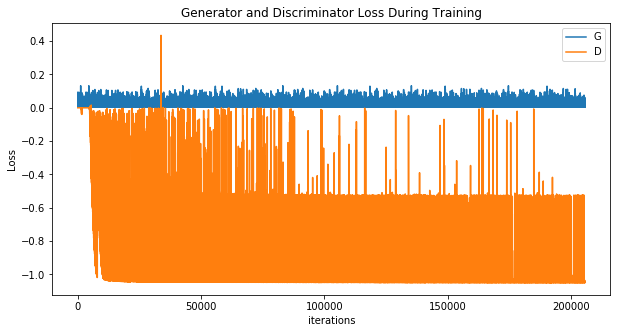

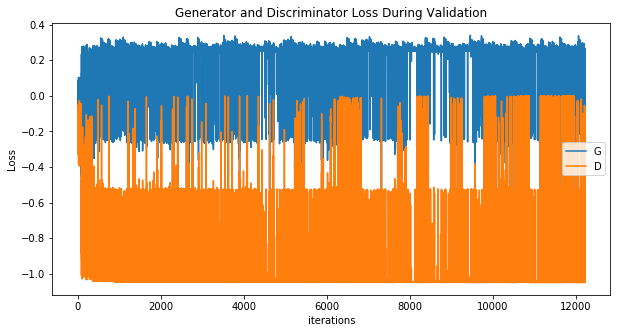

In [13]:
f=open('loss_history/train_loss_history.txt','rb')
train_loss = pickle.load(f)
f.close()
f=open('loss_history/train_loss_D_history.txt','rb')
train_D_loss = pickle.load(f)
f.close()
f=open('loss_history/val_loss_history.txt','rb')
val_loss = pickle.load(f)
f.close()
f=open('loss_history/val_loss_D_history.txt','rb')
val_D_loss = pickle.load(f)
f.close()
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(train_loss[20000:],label="G")
plt.plot(train_D_loss[20000:],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Validation")
plt.plot(val_loss[1000:],label="G")
plt.plot(val_D_loss[1000:],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
def check_result_images(step,slice=50):
    f=open('example_images/example_lr_step{}.txt'.format(step),'rb')
    lr_patches = pickle.load(f)
    f.close()
    f=open('example_images/example_sr_step{}.txt'.format(step),'rb')
    sr_patches = pickle.load(f)
    f.close()
    f=open('example_images/example_hr_step{}.txt'.format(step),'rb')
    hr_patches = pickle.load(f)
    f.close()
    f = plt.figure(figsize=(16,8))
    patch_size = lr_patches.shape[0]
    for patch in range(patch_size):
        sp = f.add_subplot(patch_size,3,patch*3+1)
        sp.axis('Off')
        sp.set_title('Low resolution patch', fontsize=16)
        plt.imshow(lr_patches[patch,0,slice,:,:],cmap='gray')
        
        sp = f.add_subplot(patch_size,3,patch*3+2)
        sp.axis('Off')
        sp.set_title('Super resolution patch', fontsize=16)
        plt.imshow(sr_patches[patch,0,slice,:,:],cmap='gray')
        
        sp = f.add_subplot(patch_size,3,patch*3+3)
        sp.axis('Off')
        sp.set_title('High resolution patch', fontsize=16)
        plt.imshow(hr_patches[patch,0,slice,:,:],cmap='gray')


**Results of patches**

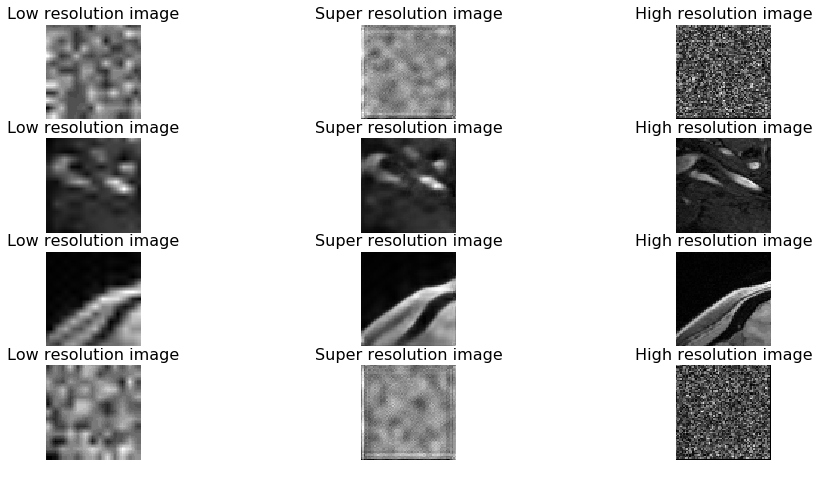

In [14]:
check_result_images(step=250000,slice=40)

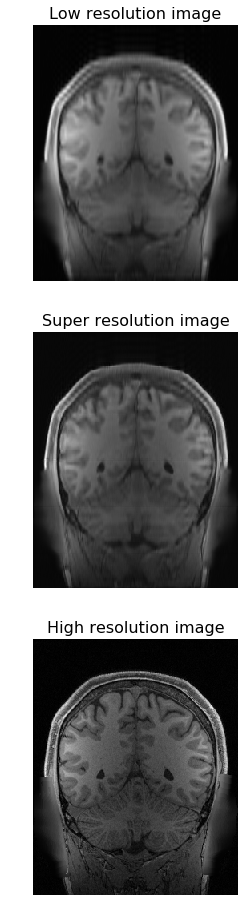

In [18]:
f=open('example_images/image_lr_step448000.txt','rb')
lr_image = pickle.load(f)
f.close()
fig = plt.figure(figsize=(16,16))
sp = fig.add_subplot(3,1,1)
sp.axis('Off')
sp.set_title('Low resolution image', fontsize=16)
lr_show=ndimage.rotate(lr_image[0,:,100,:], 90)
plt.imshow(lr_show,cmap='gray')
f=open('example_images/image_sr_step448000.txt','rb')
sr_image = pickle.load(f)
f.close()
sp = fig.add_subplot(3,1,2)
sp.axis('Off')
sp.set_title('Super resolution image', fontsize=16)
sr_show=ndimage.rotate(sr_image[0,:,100,:], 90)
plt.imshow(sr_show,cmap='gray')
f=open('example_images/image_hr_step448000.txt','rb')
hr_image = pickle.load(f)
f.close()
sp = fig.add_subplot(3,1,3)
sp.axis('Off')
sp.set_title('High resolution image', fontsize=16)
hr_show=ndimage.rotate(hr_image[0,:,100,:], 90)
plt.imshow(hr_show,cmap='gray')

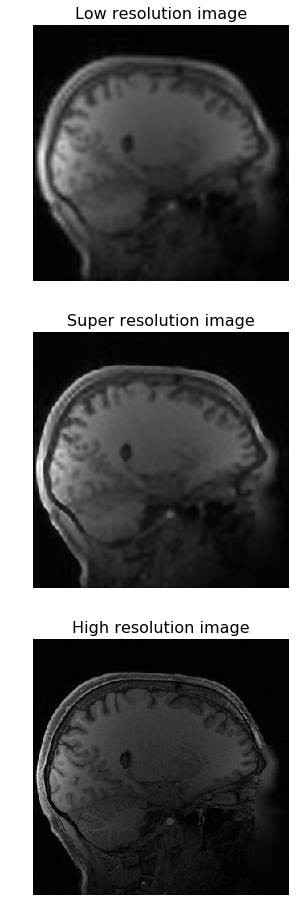

In [19]:
f=open('example_images/image_lr_step448000.txt','rb')
lr_image = pickle.load(f)
f.close()
fig = plt.figure(figsize=(16,16))
sp = fig.add_subplot(3,1,1)
sp.axis('Off')
sp.set_title('Low resolution image', fontsize=16)
lr_show=ndimage.rotate(lr_image[0,100,:,:], 90)
plt.imshow(lr_show,cmap='gray')
f=open('example_images/image_sr_step448000.txt','rb')
sr_image = pickle.load(f)
f.close()
sp = fig.add_subplot(3,1,2)
sp.axis('Off')
sp.set_title('Super resolution image', fontsize=16)
sr_show=ndimage.rotate(sr_image[0,100,:,:], 90)
plt.imshow(sr_show,cmap='gray')
f=open('example_images/image_hr_step448000.txt','rb')
hr_image = pickle.load(f)
f.close()
sp = fig.add_subplot(3,1,3)
sp.axis('Off')
sp.set_title('High resolution image', fontsize=16)
hr_show=ndimage.rotate(hr_image[0,100,:,:], 90)
plt.imshow(hr_show,cmap='gray')

## Test of depatching, and evaluation metrics ##

**Validation period patching and depatching**

In validation, evaluation, and test period, we need to input patches by order, and merge them to original image size. To reduce boundary effect, as is shown below, we cut each patches' margin by 3. After merging, we apply evaluation metrics on these images. Here is a demonstration that how this process works.

![Illustration of margin effect](./example_images/side_effect.png)

Here just for demonstration, we directly compare the evalutating measurements between a batch of low resolution images and their respective high resolution images. 

**Evaluation metrics**

To assess the quality of super-resolution, we used three image metrics: subject-wise average structural similarity index (SSIM), peak signal to noise ratio (PSNR), and normalized root mean squared error (NRMSE). They are all advanced and trusty metrics to assess the similarity between two images. The detailed calculations are:

$$
\operatorname{SSIM}(x, y)=\frac{\left(2 \mu_{x} \mu_{y}+c_{1}\right)\left(2 \sigma_{x y}+c_{2}\right)}{\left(\mu_{x}^{2}+\mu_{y}^{2}+c_{1}\right)\left(\sigma_{x}^{2}+\sigma_{y}^{2}+c_{2}\right)}
$$

$$
\begin{aligned} \mathrm{PSNR} &=10 \cdot \log _{10}\left(\frac{M A X_{I}^{2}}{M S E}\right) \\ &=20 \cdot \log _{10}\left(\frac{M A X_{I}}{\sqrt{M S E}}\right) \\ &=20 \cdot \log _{10}\left(M A X_{I}\right)-10 \cdot \log _{10}(M S E) \end{aligned}
$$

$$
\mathrm{NRMSE}=\frac{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1}|y[m, n]-x[m, n]|^{2}}{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} x[m, n]^{2}}
$$

In [20]:
from ecbm6040.patching.patchloader import depatching
from ecbm6040.metric.eval_metrics import ssim, psnr, nrmse

## demo of test

We input 10 subjects from test set to see the results.

1) Test on pretrained Generator.

In [18]:
wgan_gp = WGAN_GP(netG, netD, supervised_criterion, D_criterion, device, ngpu)
wgan_gp.test(test_loader, patch_size=patch_size, pretrainedG='models/pretrained_G_step250000', pretrainedD=' ')

WGAN testing...
Metrics: subject-wise mean SSIM = 0.9275, std = 0.0215; mean PSNR = 30.0175, std = 2.3670; mean NRMSE = 0.2876, std = 0.0693.


2) Test on mDCSRN+SRGAN.

In [31]:
wgan_gp = WGAN_GP(netG, netD, supervised_criterion, D_criterion, device, ngpu)
wgan_gp.test(test_loader, patch_size=patch_size, pretrainedG='models/WGAN_G_step442000', pretrainedD='models/WGAN_D_step442000')

WGAN testing...
Metrics: subject-wise mean SSIM = 0.9331, std = 0.0081; mean PSNR = 30.5372, std = 1.3734; mean NRMSE = 0.2485, std = 0.0343.


In [13]:
wgan_gp = WGAN_GP(netG, netD, supervised_criterion, D_criterion, device, ngpu)
wgan_gp.test(test_loader, patch_size=patch_size, pretrainedG='models/final_model_G', pretrainedD='models/final_model_D')

WGAN testing...
Metrics: subject-wise mean SSIM = 0.9269, std = 0.0217; mean PSNR = 29.9876, std = 2.5398; mean NRMSE = 0.2883, std = 0.0673.


## Discussion

1. Generator itself can conduct super-resolution. Inducing WGAN structure makes it better.
2. We start from extremely low resolution (256×64×64), which causes the task to be more difficult. The paper starts from not so "low" resolution (256×160×160).
3. Patching induces a problem: cubes that close to the edges of the image would be full of noise, which disturbs the training.